In [1]:
import sys
sys.path.append('/home/simone/Desktop/NLFF/Experiments/cumulativeReturnPeper')
import os.path
import pickle

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU,ReLU,Activation
from keras import optimizers,regularizers
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.losses import binary_crossentropy
from keras.engine.topology import Layer
from imblearn.over_sampling import SMOTE, ADASYN


from technicalSignals import Indicators



#CPU RUN
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']

TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]

technical_feat = True
kind_of_dataset = 'Summary'
NN_INPUT_DIM = 66

In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = Indicators.momentum(price, 30)
            price['mom_50'] = Indicators.momentum(price, 50)
            price['mom_100'] = Indicators.momentum(price, 100)
            price['mom_150'] = Indicators.momentum(price, 150)
            price['SMA_30'] = Indicators.SMA(price, 30)
            price['SMA_50'] = Indicators.SMA(price, 50)
            price['SMA_100'] = Indicators.SMA(price, 100)
            price['SMA_150'] = Indicators.SMA(price, 150)
            price['in_BBands'] = Indicators.inBBands(price)
            price['eccessVolumes'] = Indicators.eccessOfVolumes(price)

            
        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 20, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150',
                                  'SMA_30','SMA_50','SMA_100','SMA_150','in_BBands, eccessVolumes']
            X = pd.concat([X, price[technical_features]],axis=1)
            
        X = np.nan_to_num(np.asarray(X, dtype=float))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            s =np.sign(cumulative_return)
            y.append(0 if s==-1 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])

        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    
    def get_dataset_for_trend_all_tickers(self, init, finish,kind, perc_train = 0.7, technicalFeatures=False):
        x_tv_all = []
        y_tv_all = []
        x_test_all = []
        y_test_all = []
        dates_test_prev = None
        for ticker in tickers:
            self.load_dataset(ticker, kind, technicalFeatures)
            (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish, perc_train = 0.7)
            if(dates_test_prev):
                assert dates_test == dates_test_prev
            x_tv_all += x_tv.tolist()
            y_tv_all += y_tv.tolist()
            x_test_all += x_test.tolist()
            y_test_all += y_test.tolist()
        x_tv_all = np.asarray(x_tv_all)
        y_tv_all = np.asarray(y_tv_all)
        x_test_all = np.asarray(x_test_all)
        y_test_all = np.asarray(y_test_all)
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        min_max_scaler.fit(np.concatenate((x_tv_all,x_test_all)))
        x_tv_all = np.asarray(min_max_scaler.transform(x_tv_all))
        x_test_all = np.asarray(min_max_scaler.transform(x_test_all))
        return (x_tv_all,y_tv_all),(x_test_all,y_test_all), dates_test
    
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled

In [4]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator / (denominator + K.epsilon())

def buildNN2(n_expected_active_units, dropout = 0.5, max_norm_val = 3.0):
    #dropout is the probability of retaining a unit (contrary of paper)
    n_units = math.floor(n_expected_active_units / (1 - dropout)) 
    model = Sequential()  
    model.add(Dense(n_units, input_dim=NN_INPUT_DIM, kernel_constraint=max_norm(max_norm_val))) #Linear activ. funct Wx+b
    model.add(BatchNormalization()) # Batch norm applied only on the part without activation (done more often)
    model.add(LeakyReLU()) # ReLU can be less sensible to noise? there is an entire area in which the output is 0
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/2), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(math.floor(n_units/4), kernel_constraint=max_norm(max_norm_val))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', matthews_correlation])
    return model



def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
def plot_hystory(history,max_norm,drop,n_units):
    f, axarr = plt.subplots(2, sharex=True)
    f.set_figheight(7)
    f.set_figwidth(10)
    axarr[0].plot(history.history['acc'],'g', label='accuracy_train')
    axarr[0].plot(history.history['val_acc'],'r', label='accuracy_val')
    axarr[1].semilogy(history.history['loss'],'g',label='loss_train')
    axarr[1].semilogy(history.history['val_loss'],'r',label='loss_val')
    #axarr[1].set_ylim([0,2])
    axarr[1].legend()   
    axarr[0].legend()   
    axarr[0].set_title('max_norm: '+str(max_norm)+' drop: '+str(drop)+' n_units: '+str(n_units))   
    plt.show() 
            
            
def cv(x_tv,y_tv):
    max_norm_space=[0.5, 1, 3]
    drop_space=[0.5]
    n_unit_space=[2, 4, 8]

    best_mcc = -float(np.inf)
    best_max_norm = 0
    best_drop = 0
    best_n_units = 0
    best_epochs = 0
    for max_norm in max_norm_space:
        for drop in drop_space:
            for n_units in n_unit_space:
                print('.', end='')
                
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMCC = 0
                nn_model = buildNN2(n_expected_active_units=n_units, dropout = drop, max_norm_val = max_norm)
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    x_train,y_train=smote(x_train,y_train)
                    x_val,y_val=smote(x_val,y_val)
                    
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    history = nn_model.fit(x_train, y_train, epochs = 600,batch_size =256, verbose=0, 
                                           validation_data=(x_val, y_val),shuffle=True)
                    mcc = max(history.history['val_matthews_correlation'])
                    epochs = max(np.argmax(history.history['val_matthews_correlation']), 70)
                    cvMCC += mcc/4
                    reset_weights(nn_model)
                if(cvMCC > best_mcc):
                    best_mcc = cvMCC
                    best_max_norm = max_norm
                    best_drop = drop
                    best_n_units = n_units
                    best_epochs = epochs
                
    return (best_max_norm, best_drop, best_n_units, best_epochs)


model_selection_results = {
    (-48, 0): (0.5, 0.5, 8, 70),
    (-35, 0): (1, 0.5, 8, 195),
    (-28, 0): (0.5, 0.5, 4, 302),
    (-7, 0): (0.5, 0.5, 2, 421),
    (-1, 0): (0.5, 0.5, 8, 203),
    (1, 2): (3, 0.5, 8, 276),
    (1, 8): (1, 0.5, 4, 508),
    (1, 29): (1, 0.5, 4, 495),
    (1, 36): (0.5, 0.5, 8, 70),
    (1, 50): (0.5, 0.5, 4, 422)}




====================  trend:  -48   0  ==================== 


==== Test ===
(0.5, 0.5, 8)


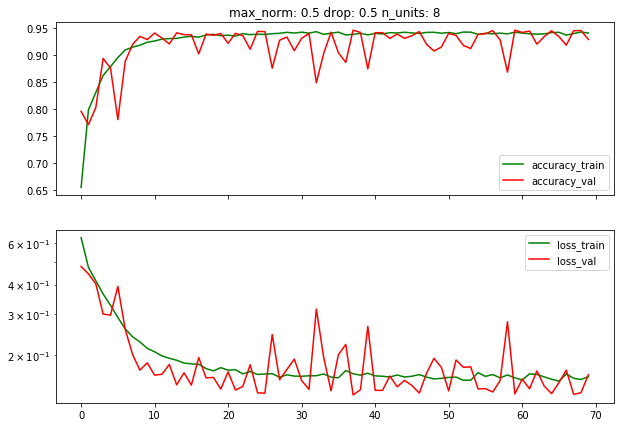

test Acc:  0.9283393504817563  test MCC:  0.8586733441536873
[[2196   62]
 [ 335 2947]]



====================  trend:  -35   0  ==================== 


==== Test ===
(1, 0.5, 8)


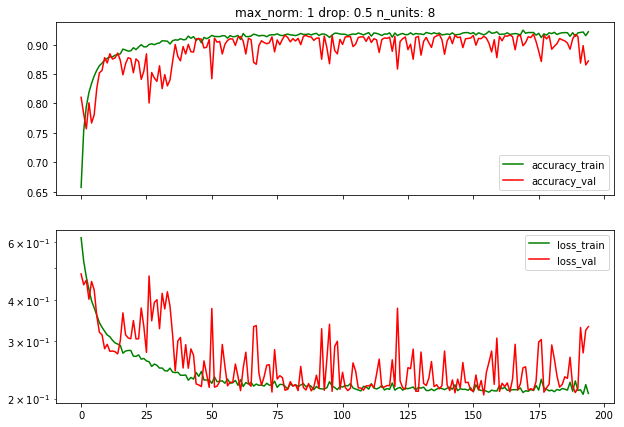

test Acc:  0.8722222224785863  test MCC:  0.7615628098242796
[[2252   74]
 [ 639 2615]]



====================  trend:  -28   0  ==================== 


==== Test ===
(0.5, 0.5, 4)


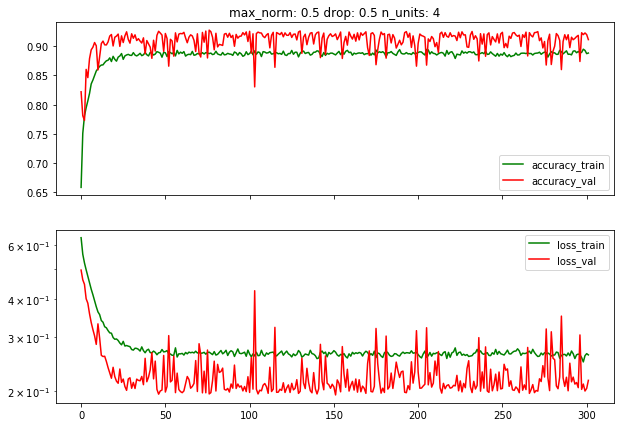

test Acc:  0.9114285724503653  test MCC:  0.8196352681667692
[[2034  359]
 [ 137 3070]]



====================  trend:  -7   0  ==================== 


==== Test ===
(0.5, 0.5, 2)


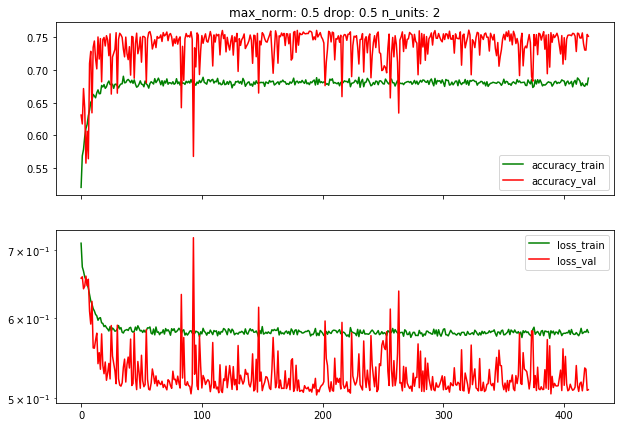

test Acc:  0.7514134276460843  test MCC:  0.4979686071593319
[[1829  764]
 [ 643 2424]]



====================  trend:  -1   0  ==================== 


==== Test ===
(0.5, 0.5, 8)


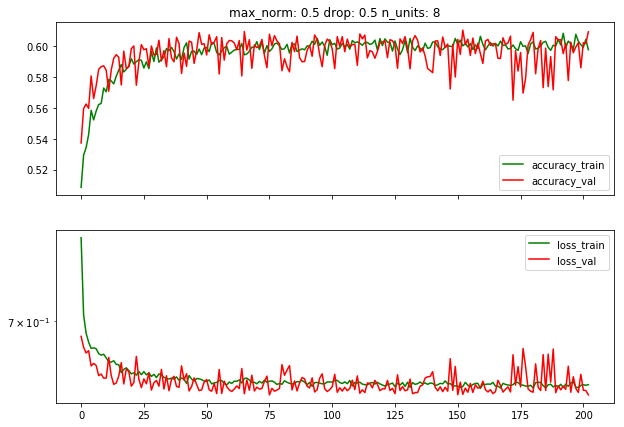

test Acc:  0.608978873407337  test MCC:  0.20868632315232727
[[1338 1306]
 [ 915 2121]]



====================  trend:  1   2  ==================== 


==== Test ===
(3, 0.5, 8)


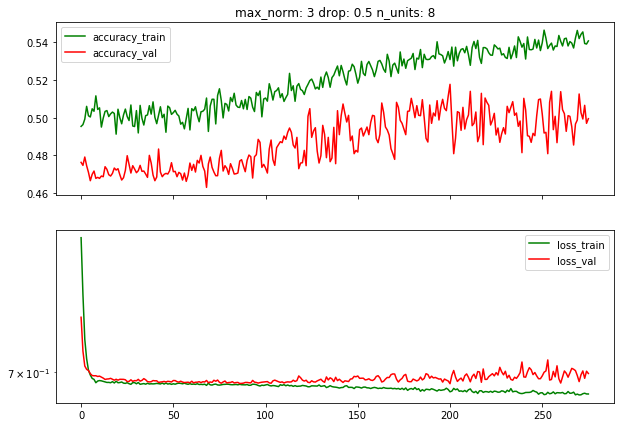

test Acc:  0.4994708993237275  test MCC:  0.014657030788650799
[[1626 1010]
 [1828 1206]]



====================  trend:  1   8  ==================== 


==== Test ===
(1, 0.5, 4)


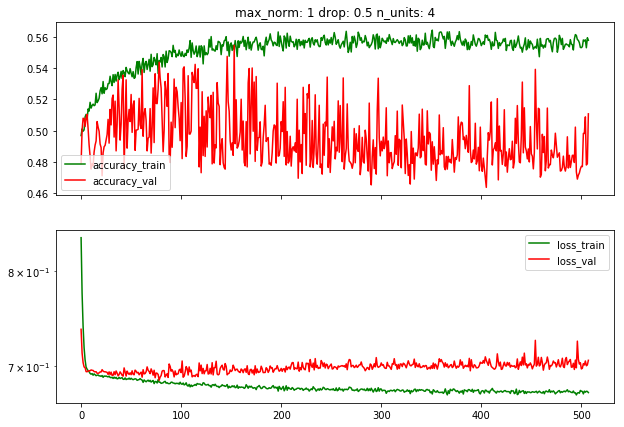

test Acc:  0.5107964601769911  test MCC:  0.06221370288298682
[[1913  676]
 [2088  973]]



====================  trend:  1   29  ==================== 


==== Test ===
(1, 0.5, 4)


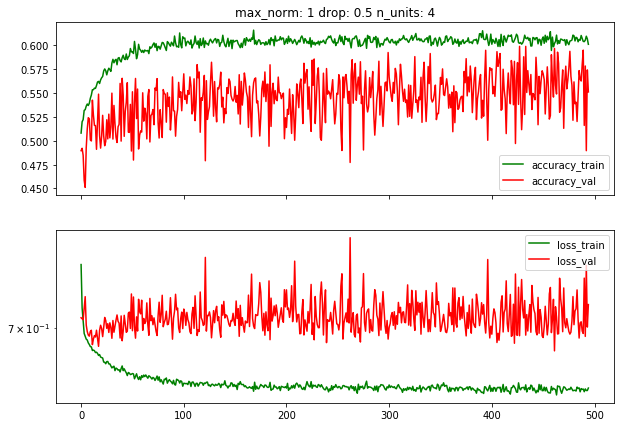

test Acc:  0.551162789695378  test MCC:  0.13661644942199772
[[1629  763]
 [1746 1452]]



====================  trend:  1   36  ==================== 


==== Test ===
(0.5, 0.5, 8)


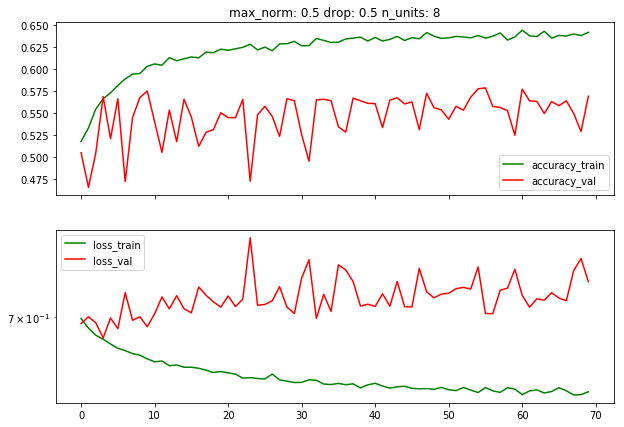

test Acc:  0.5689407532048183  test MCC:  0.03658308305410157
[[ 421 1902]
 [ 499 2748]]



====================  trend:  1   50  ==================== 


==== Test ===
(0.5, 0.5, 4)


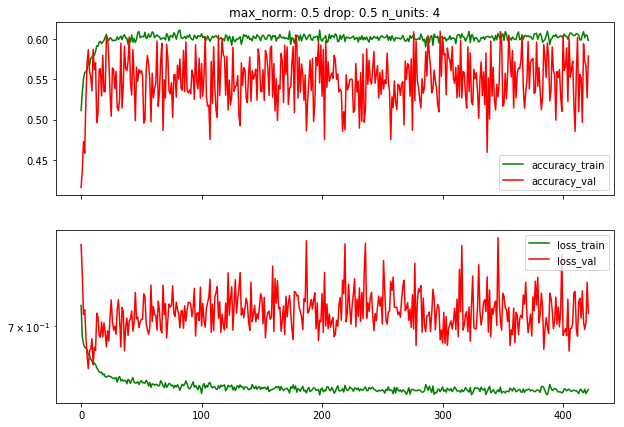

test Acc:  0.5793851714022121  test MCC:  0.12858789392614878
[[1087 1145]
 [1181 2117]]


In [5]:
for (init, finish) in TREND_WINDOWs:
    print('\n\n\n====================  trend: ',init,' ',finish, ' ==================== \n\n')
    ds = DatasetManager()
    #ds.load_dataset(ticker = ticker, kind = kind_of_dataset, technicalFeatures=technical_feat)
    (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend_all_tickers(init,finish,kind_of_dataset,perc_train=0.7,technicalFeatures=True)
    if (init, finish) in model_selection_results:
        (best_max_norm, best_drop, best_n_units, best_epochs) = model_selection_results[(init, finish)]
    else:
        (best_max_norm, best_drop, best_n_units, best_epochs) = cv(x_tv,y_tv)        
        model_selection_results[(init, finish)] = (best_max_norm, best_drop, best_n_units, best_epochs)
    nn_model = buildNN2(n_expected_active_units=best_n_units, dropout = best_drop, max_norm_val = best_max_norm)
    
    (x_tv,y_tv) = smote(x_tv,y_tv)
    history = nn_model.fit(x_tv, y_tv, epochs = best_epochs,batch_size =256, verbose=0, validation_data=(x_test, y_test),shuffle=True)
    y_pred = nn_model.predict(x_test, batch_size=256, verbose=0)
    y_pred = [1 if y>0.5 else 0 for y in y_pred]
    print('==== Test ===')
    print((best_max_norm, best_drop, best_n_units))
    plot_hystory(history,best_max_norm,best_drop,best_n_units)  
    acc = history.history['val_acc'][-1]
    confmatrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confmatrix.ravel()
    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
    mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
    print('test Acc: ',acc,' test MCC: ',mcc)
    print(confmatrix)

    


In [ ]:
model_selection_results